In [261]:
%%capture
!pip install torch

In [262]:
from IPython.display import Image
from ipywidgets import interact, SelectionSlider
from utils import *
import torch
import torch.nn as nn

## 2. Generative Adversarial Networks - 35 points

Please review Lecture 11 for the notation and the setup in this exercise, and the supplementary lecture on deep learning with PyTorch for the coding tricks.

After the LLM boom, Kocho realized his coding skills have become useless and he wants to make a career change. As Kocho cannot dance, he had to drop his dream of becoming a tiktok influencer. Kocho realized a lot of young people was creating clothing brands, and in his poor understanding of supply and demand, he thought this meant there was a high demand. But Kocho only knows how to code! How is he supposed to design clothes? Apparently there is this kind of AI called Wasserstein Generative Adversarial Networks (WGANs) that can do it for him.

Your goal in this notebook is to fill in the gaps in Kocho's knowledge on how to get his WGAN to work. Specifically, both his generator neural network $h_\mathbf{x}$ (that outputs fake images) and dual variable neural network $d_\mathbf{y}$ (that scores images) are defined as convolutional neural networks in the following function classes:

\begin{equation}
\begin{aligned}
    \mathcal{H} & :=\{h: \mathbb{R}^{D} \to [0, 1]^{28 \times 28}| h_{\mathbf{x}}(\omega)=\sigma(c^T(\texttt{relu}(c^T(\texttt{relu}(c^T(\texttt{relu}(c^T(\omega; X_1, \mu_1));X_2, \mu_2));X_3,\mu_3));X_4, \mu_4))\}, \\
    \qquad \mathcal{D} & := \{d: [0, 1]^{28 \times 28} \to \mathbb{R} | d_{\mathbf{y}}({\bf a})= Y_3 \cdot \texttt{relu}(c(\texttt{relu}(c({\bf a};Y_1,\nu_1));Y_2,\nu_2)) + \nu_3
    \},
\end{aligned}
\end{equation}

where $\mathbf{x} =[\mu_1;\mu_2;\mu_3;\mu_4;{X_1};{X_2};{X_3};X_4]$ are the "generator" parameters, $\mathbf{y} =[\nu_1;\nu_2;\nu_3;{Y_1};{Y_2}; Y_3] $ are the
"dual" or the "discriminator" parameters, $c$ and $c^T$ are the learnable 2d convolution and transposed convolution operators, $D$ is the noise dimension (a hyperparameter) and $\sigma$ is the sigmoid function.

In the following cells, you will implement the two neural networks as well as the spectral normalization ([Myato 2018](https://arxiv.org/abs/1802.05957)) and weight clipping ([Petzka 2017](https://arxiv.org/abs/1709.08894)) methods for enforcing a Lipschitz constraint on the dual variable.

**(1)** (3 points) Implement the convolutional neural network for the generator below. See `torch.nn.Sequential` docs for a start.

In [263]:
class Generator(nn.Module):

    def __init__(self, noise_dim=100):
        super().__init__()

        self.inner = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_dim, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=2),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, omega):
        out = self.inner(omega)
        return out

A critical aspect of WGANs is Lipschitzness of the discriminator. We know that the Lipschitz constant of a linear layer in the form $\mathbf{b} = \mathbf{W}\mathbf{a}$ is given by $\left|\left|\mathbf{W}\right|\right|_{2}$. We also know that a 2D circular convolution with kernel $\mathbf{K} \in \mathbb{R}^{k\times k}$ can be represented as a linear transformation of the flattened image, i.e., $\text{flat}(\mathbf{b}) = \mathbf{W}_{\mathbf{K}}\text{flat}(\mathbf{a})$ ([Sedghi 2019](https://arxiv.org/abs/1805.10408)). But what happens if we increase the `stride` parameter of the convolutional operator? The stride of the convolutional layer just results in a downsamplig of the output. In this exercise we will compute the Lipschitz constant of convolutional layers with `stride=2`.

**Example**
The 1D circular convolution $\mathbf{b} = \mathbf{k} \circledast \mathbf{a}$ with the kernel $\mathbf{k} = [k_1, k_2, k_3] \in \mathbb{R}^{3}$ and $\mathbf{a} \in \mathbb{R}^{d}, \mathbf{b} \in \mathbb{R}^{d}$ can be written as:

$$
    \mathbf{b} = \left(\begin{matrix}
        k_2 & k_3 & 0 & \cdots & & 0 & k_1\\
        k_1 & k_2 & k_3 & 0 & \cdots & & 0 \\
        0 & k_1 & k_2 & k_3 & 0 & \cdots & 0 \\
        &&&\vdots \\
        0 & \cdots &  & 0 & k_1 & k_2 & k_3 \\
        k_3 & \cdots &  & 0 & 0 & k_1 & k_2 \\
    \end{matrix}\right)\mathbf{a} = \mathbf{W}_{\mathbf{k}}\mathbf{a}\,,
$$
where $\mathbf{W}_{\mathbf{k}} \in \mathbb{R}^{d\times d}$. With `stride=2`, the operation results in:
$$
    \hat{\mathbf{b}} = \left(\begin{matrix}
        k_2 & k_3 & 0 & \cdots & & & & 0 & k_1\\
        0 & k_1 & k_2 & k_3 & 0 & \cdots & & & 0 \\
        0 & 0 & 0 & k_1 & k_2 & k_3 & 0 & \cdots & 0 \\
        &&&&\vdots \\
        0 & \cdots & & & & 0 & k_1 & k_2 & k_3 \\
        k_3 & \cdots & & & & 0 & 0 & k_1 & k_2 \\
    \end{matrix}\right)\mathbf{a} = \hat{\mathbf{W}}_{\mathbf{k}}\mathbf{a}
$$
where $\hat{\mathbf{W}}_{\mathbf{k}} \in \mathbb{R}^{d/2\times d}$ and $d$ must be divisible by $2$.

**(2)** (2 points) What is the Lipschitz constant of the convolutional layer with `stride=2` from the previous example?

**Hint** Try finding a matrix $\mathbf{S}\in \mathbb{R}^{d/2 \times d}$ so that $\hat{\mathbf{W}}_{\mathbf{k}} = \mathbf{S}\mathbf{W}_{\mathbf{k}}$, what is $\mathbf{S}\mathbf{S}^{\top}$?



<span style="color:red">

**Solution**

$$
    \mathbf{S} =\left(\begin{matrix}
        1 & 0 & 0 & \cdots & & & & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & \cdots & & & 0 \\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
        &&&&\vdots \\
        0 & \cdots & & & & 1 & 0 & 0 & 0 \\
        0 & \cdots & & & & 0 & 0 & 1 & 0 \\
    \end{matrix}\right)
$$

And $\mathbf{S}\mathbf{S}^{\top} = \mathbf{I}_d$. 2-norm is square root lambda max A AT, so $||\mathbf{S}||_2 = 1$.

$$
    L = ||\hat{\mathbf{W}}_k||_2  = ||\mathbf{S}\mathbf{W}_k||_2 \leq ||\mathbf{S}||_2||\mathbf{W}_k||_2 = ||\mathbf{W}_k||_2,
$$

So the Lipschitz constant of the convolution layer with stride 2 is upper bounded by that of stride 1.
</span>

Now that we know how the stride affects the Lipschitz constant, we are ready to perform `spectral_normalization` and `weight_clipping`.

**(3)** (14 points) Implement below the convolutional network with circular padding for the discriminator and implement the spectral normalization and weight clipping methods. Use the findings from Theorem 6 in [Sedghi 2019](https://arxiv.org/abs/1805.10408) regarding the singular values of the linear form of a convolutional layer and check the pseudocode in the summary of results. Note that `torch.fft.fft(W,dim=-1)` computes the Discrete Fourier Transform along the last dimension of the tensor `W`. Be careful with the input image size at each layer! Also note that since the we are interested in the maximum singular value, we can simply use `torch.linalg.norm(..., ord=2)` instead of computing the SVD.

**Remark:** The `spectral_normalization` and `weight_clipping` methods do not need to return a value. They should modify the appropriate parameters in $\mathbf{y}$ of the dual network $d_{\mathbf{y}}$ in place. Make sure to distinguish between convolutional and linear layers when performing spectral normalization. Remember not to track gradients in those operations.

In [264]:
class DualVariable(nn.Module):

    def __init__(self, c=1e-2, mode="spectral_norm"):
        super().__init__()
        self.c = c
        self.mode = mode

        self.inner = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1, padding_mode='circular'),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode='circular'),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1)
        )

    def forward(self, x):
        out = self.inner(x)
        return out

    def enforce_lipschitz(self):
        if self.mode == "spectral_norm":
            self.spectral_normalisation()
        elif self.mode == "weight_clip":
            self.weight_clipping()
        else:
            raise ValueError("Invalid enforce_lipschitz mode")

    def spectral_normalisation(self):
        """
        Perform spectral normalisation, forcing the singular values of the linear form of the layer to be upper bounded by c.
        """
        with torch.no_grad():
            input_shape = (28, 28)
            for layer in self.inner:
                if isinstance(layer, nn.Conv2d):
                    W = layer.weight.data
                    FT = torch.fft.fft2(W, input_shape, dim=(-2, -1)) # print(FT.shape) # torch.Size([d, c, k, k])
                    s_b = torch.linalg.norm(FT, dim=(-2, -1), ord=2) # print(s_b.shape) # torch.Size([d, c])
                    s_m = torch.max(s_b) # print(s_m.shape) # torch.Size([])
                    layer.weight.data = layer.weight.data / s_m * self.c

                    # Compute output dimensions
                    H_in, W_in = input_shape
                    H_out = (H_in + 2 * layer.padding[0] - layer.kernel_size[0]) // layer.stride[0] + 1
                    W_out = (W_in + 2 * layer.padding[1] - layer.kernel_size[1]) // layer.stride[1] + 1
                    input_shape = (H_out, W_out)

                elif isinstance(layer, nn.Linear):
                    W = layer.weight.data
                    s = torch.linalg.norm(W, ord=2)
                    layer.weight.data = layer.weight.data / s * self.c

    def weight_clipping(self):
        """
        Perform weight clipping, forcing the absolute values of the parameters to be upper bounded by c.
        """
        conv1 = self.inner[0]
        conv2 = self.inner[2]
        linear = self.inner[5]

        conv1.weight.data.clamp_(-self.c, self.c)
        conv2.weight.data.clamp_(-self.c, self.c)
        linear.weight.data.clamp_(-self.c, self.c)

**(4)** (1 point) Torch implements spectral normalization through `torch.nn.utils.parametrizations.spectral_norm`. Check the norm of the convolutional layer before and after normalization. What do you observe? Can you explain why torch fails?

**Hint** Compute the norm of the kernel vector, how does it change after `torch.nn.utils.parametrizations.spectral_norm`?

In [265]:
def circulant(tensor, d=5):
    """get the circulant matrix arising from circular convolution with tensor over d-dimensional inputs.
    E.g. tensor=[0,1,2], dim=0 --> [[0,1,2],[2,0,1],[1,2,0]]"""
    S = len(tensor)
    tensor = torch.cat([tensor[1:], torch.zeros(d-S), torch.tensor([tensor[0]])])

    tmp = torch.cat([tensor.flip((0,)), torch.narrow(tensor.flip((0,)), dim=0, start=0, length=d-1)])
    return tmp.unfold(0, d, 1).flip((-1,))

#Define input
d=5
x = torch.rand(d)

#Initialize convolutional kernel
conv = nn.Conv1d(1,1, kernel_size=3, stride=1, padding=1,padding_mode='circular', bias=False)
print("Kernel:\n",conv.weight.data)

#Compute the circulant matrix
circ = circulant(conv.weight.data.squeeze(), d=d)
print("Circulant matrix representation:\n", circ)

#Check that the convolution is equivalent to the matrix-vector product
print("Error:", torch.norm(conv(x.unsqueeze(0)).squeeze() - circ @ x))

spectral_norm_before = torch.linalg.norm(circ, ord=2)
kernel_norm_before = torch.linalg.norm(conv.weight.data, dim=-1, ord=2)

print('Spectral norm before', spectral_norm_before)
print('Kernel norm before', kernel_norm_before)

#Same convolutional kernel with torch's spectral normalization parametrization
conv_norm = nn.Conv1d(1,1, kernel_size=3, stride=1, padding=1,padding_mode='circular', bias=False)
conv_norm.weight.data = conv.weight.data.clone()

conv_norm = torch.nn.utils.parametrizations.spectral_norm(conv_norm)
print("Kernel after normalization:\n",conv_norm.weight.data)

circ_norm = circulant(conv_norm.weight.data.squeeze(), d=d)

spectral_norm_after = torch.linalg.norm(circ_norm, ord=2)
kernel_norm_after = torch.linalg.norm(conv_norm.weight.data, dim=-1, ord=2)
print('Spectral norm after', spectral_norm_after)
print('Kernel norm after', kernel_norm_after)



Kernel:
 tensor([[[ 0.5586, -0.4044, -0.4756]]])
Circulant matrix representation:
 tensor([[-0.4044, -0.4756,  0.0000,  0.0000,  0.5586],
        [ 0.5586, -0.4044, -0.4756,  0.0000,  0.0000],
        [ 0.0000,  0.5586, -0.4044, -0.4756,  0.0000],
        [ 0.0000,  0.0000,  0.5586, -0.4044, -0.4756],
        [-0.4756,  0.0000,  0.0000,  0.5586, -0.4044]])
Error: tensor(1.4901e-08, grad_fn=<LinalgVectorNormBackward0>)
Spectral norm before tensor(1.0540)
Kernel norm before tensor([[0.8378]])
Kernel after normalization:
 tensor([[[ 0.6668, -0.4828, -0.5677]]])
Spectral norm after tensor(1.2581)
Kernel norm after tensor([[1.0000]])


<span style="color:red">

**Comments**

PyTorch’s spectral_norm does not correctly normalize the spectral norm of convolutional layers. It does correctly normalize the kernel. Pytorch assumes that the layer weights will be used as a linear transformation over the data. This is not the case with convolutional layers, with which we apply a convolution function using the weight filters. For the spectral norm to work it should be applied on the 2D FFT of the filters.
</span>

**(5)** (1 point) Implement a stochastic estimate of the objective function of the WGAN minimax game (in the cell below):

$$
\min_{\mathbf{x} \in \mathcal{X}} \max_{\mathbf{y} \in \mathcal{Y}}
\mathbb{E}[d_{\mathbf{y}}({\bf a})] - \mathbb{E}[d_{\mathbf{y}}(h_{\mathbf{x}}(\omega))] =
\min_{h \in \mathcal{H}} \max_{d \in \mathcal{F}}
\mathbb{E}[d({\bf a})] - \mathbb{E}[d(h(\omega))],
$$

In [266]:
def objective_d(d, g, data_sample, noise_sample): # maximize
    return d(data_sample).mean() - d(g(noise_sample)).mean()

def objective_g(d, g, noise_sample): # minimize
    return -d(g(noise_sample)).mean()

**(6)** (10 points) Implement an alternating gradient ascent/descent update, training the generator 1 time for every `d_ratio` dual updates. More specifically, you will implement the conceptual algorithm below using the parameters of the neural networks

$$
\begin{aligned}
d^{k+1} &= \text{EnforceLipschitz} (d^k + \gamma \text{SG}_d(d^k, h^k)), & (\text{if}~k~\text{mod}~d_{\text{ratio}} \neq 0)\\
h^{k+1} &= h^{k} - \gamma \text{SG}_h(d^{k+1}, h^k) & (\text{if}~ k~\text{mod}~d_{\text{ratio}} =0),
\end{aligned}
$$

where $\text{SG}$ is the stochastic gradient oracle. To perform the optimization, you have two `torch` optimizers `d_optim` and `g_optim`, which have a `.step()` method that updates the discriminator and generator parameters respectively.

Use the objective function you have just written. The iteration count is held by the `step_k` argument. The argument `d_ratio` defines how many more times we train the discriminator than train the generator.

For later, to display the progress, write the function so that it returns the value of the objective function.

**Hints**: Don't forget that the generator seeks to minimize and the discriminator seeks to maximize. Torch optimizers step in the _negative_ gradient direction, keep that in mind.

In [267]:
def alternating_update(step_k, d, g, d_optim, g_optim, noise_samples, real_samples, d_ratio=2):
    if step_k % d_ratio != 0:
        d_optim.zero_grad()
        loss = objective_d(d, g, real_samples, noise_samples)
        loss.backward()
        d_optim.step()
        d.enforce_lipschitz()
    else:
        g_optim.zero_grad()
        loss = objective_g(d, g, noise_samples)
        loss.backward()
        g_optim.step()
    return loss

With all the ingredients in hand, we can train Kocho's WGAN.

The following cell defines the two networks.

In [268]:
# Hyperparameters
n_epochs = 100
noise_dim = 100
mode = "spectral_norm" # "weight_clip" # choice for enforce_lipschitz
c = 2.0 if mode == "spectral_norm" else 1e-2 # hyperparameter for the enforce_lipschitz methods

device = "cuda" # Change this if you can and want to use a GPU device
d = DualVariable(c=c, mode=mode).to(device)
g = Generator(noise_dim=noise_dim).to(device)

**(7)** (2 points) Define an optimizer for each of the networks. We recommend choosing `Adam` with a learning rate of $2 \cdot 10^{-4}$ and $(\beta_1, \beta_2)=(0.5, 0.999)$.

In [269]:
d_optim = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0.5, 0.999), maximize=True)
g_optim = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999), maximize=False)

The following cell runs the training loop, this might take a few minutes.

In [270]:
train(d, g, d_optim, g_optim, alternating_update, device=device,
      n_epochs=n_epochs, num_test_samples=100, noise_dim=noise_dim, f_ratio=2, mode=mode)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Once the training is complete, you can visualize the training process in the following cell. Use the slider to scroll through generated image collages from every epoch.

In [271]:
def show_image(epoch):
    return Image(f"generated_images_{mode}/epoch_{epoch}.png")
interact(show_image, epoch=SelectionSlider(
    options=range(n_epochs),
    value=0,
    description="Epoch:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True
))

interactive(children=(SelectionSlider(continuous_update=False, description='Epoch:', options=(0, 1, 2, 3, 4, 5…

<function __main__.show_image(epoch)>

Screenshot because I'm getting the following when saving from Google Colab:
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"version_major":2,"version_minor":0,"model_id":"75b9b9bded3f4b969c38ce533a5ed25c"}


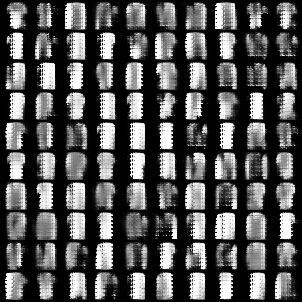

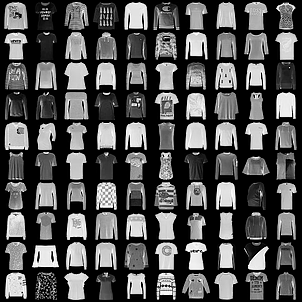

In [272]:
Image(f"generated_images_{mode}/epoch_-1.png") # real images

**(8)** (2 points) Briefly comment on what you observe, will Kocho be able to sell any of these hoodies/T-shirts? Play with the network parameter sizes and the other hyperparameters, all while keeping in mind the difficulties of min-max optimization you've analyzed in the previous notebook.

<span style="color:red">

**Comments**

Kocho's clothing pieces mostly look like clothing, but there is nothing that would make them particularly appealing. That is, unless the poorly AI-generated look is appealing in itself. We see Kocko's model generate pieces of clothing that use both long and short sleeves, and other odd combinations.
</span>